# Convolutional Neural Networks for Handwritten Digit Recognition

Object recognition is one of the most exciting tasks in the field of Computer Vision. The goal is to detect and identify objects in an image. The most popular dataset in object recognition involves recognizing handwritten digits. In this part of the lab, we will develop a convolutional neural network for classifying handwritten digits using the [Keras](https://keras.io/) library. We will evaluate the neural network on the well-known [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The dataset was created by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models. Each instance corresponds to the image of a digit taken from a scanned document. Each image is a 28 by 28 pixel square (784 pixels total), and the digits are normalized in size and centred. There are 10 digits in total (0 to 9). Hence, there are 10 classes in total. The dataset is spit into a training set consisting of 60,000 images and a test set of 10,000 images.

Keras provides a function for directly loading the MNIST dataset. The dataset is downloaded automatically the first time this function is called and is stored in the disk. Run the following code to load the MNIST dataset. Then, use the ``show`` function (already implemented) to visualize a digit of the training set.

2


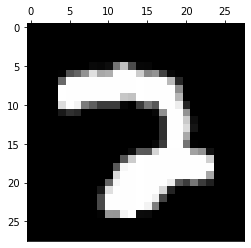

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow.keras.datasets import mnist

def show(image):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap='gray')
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


#your code here
n=120
show(X_train[n,:,:])
print(y_train[n])

To reduce training time, we will carry out experiments only on a subset of the dataset. Specifically, the first 10,000 instances of the training set and the first 1,000 instances of the test set will serve as our new training and test sets, respectively.

In [13]:
X_train = X_train[:10000,:,:]
y_train = y_train[:10000]
X_test = X_test[:1000,:,:]
y_test = y_test[:1000]

print("Shape of training matrix:", X_train.shape)
print("Shape of test matrix:", X_test.shape)

Shape of training matrix: (10000, 28, 28)
Shape of test matrix: (1000, 28, 28)


After loading the MNIST dataset and reducing its size, it is necessary to reshape all the instances so that their shape is the one a CNN would expect. In Keras, the layers used for two-dimensional convolutions expect the depth of the input image along with its dimensions. In the case of full-color images, the depth is equal to 3 and each dimension corresponds to its red, green and blue components. The images contained in the MNIST dataset are greyscale, hence, the depth is equal to 1. Therefore, to be able to apply two-dimensional convolutions, it is necessary to transform the shape of each image from (width, height) to (width, height, depth). Make use of the [reshape](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.reshape.html) function of NumPy to add an extra dimension to the training and test matrices.

In [14]:
#your code here
# We add one more dimension because the 'Conv2D' Keras layer needs to have 3 dims for images : with, height , depth

X_train=X_train.reshape((10000, 28,28,1))
X_test=X_test.reshape((1000, 28, 28,1))

The final preprocessing step is to convert the type of the images to float32, normalize their values to the range [0,1] and to encode the class labels using a one-hot scheme.

In [15]:
y_train

array([5, 0, 4, ..., 6, 9, 7], dtype=uint8)

In [16]:
from tensorflow.keras.utils import to_categorical

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 # To standardize the values between 0 and 1
X_test /= 255  # To standardize the values between 0 and 1
print("Shape of training matrix:", X_train.shape)
print("Shape of test matrix:", X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes) # transform the value into a OneHot vector : 0 , but 1 in the correct value
y_test = to_categorical(y_test, num_classes)

Shape of training matrix: (10000, 28, 28, 1)
Shape of test matrix: (10000, 28, 28, 1)
10000 train samples
1000 test samples


Upon completing the preprocessing pipeline, we can now start developing the [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) architecture. Keras provides rich functionality for building CNNs since it offers various methods for creating convolutional and pooling layers. We first initialize a Sequential model.

In [25]:
from tensorflow.keras.models import Sequential

#your code here
model=Sequential()

We next add a two-dimensional convolution layer to our model. This layer will create a convolution kernel that is convolved with the layer input to produce a tensor of outputs. Use the [`Conv2D`](https://keras.io/layers/convolutional/#conv2d) method of Keras to generate a convolution layer with 32 filters of size (3,3) and a ReLU activation function.

In [26]:
from tensorflow.keras.layers import Conv2D

#your code here
# We could have added a "Reshape" layer to reshape the inputs
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', input_shape=(28,28,1),padding="valid"))
# stride = how much pixel he will move the kernel to get the other 

Add a second convolution layer to the model. Set the number of filters to 64 and their size to (2,2). As in the case of the first layer use a ReLU activation function.

In [27]:
#your code here
model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu',padding="valid"))

Then, define a pooling layer using the [`MaxPooling2D`](https://keras.io/layers/pooling/#maxpooling2d) method of Keras. Max pooling reduces the number of parameters in the model by sliding a 2x2 pooling filter on the output of the previous layer and taking the max of the 4 values in the 2x2 filter.

In [28]:
from tensorflow.keras.layers import MaxPooling2D

#your code here
model.add(MaxPooling2D(pool_size=(2,2)))

The next layer is a regularization layer using dropout. Use the [`Dropout`](https://keras.io/layers/core/#dropout) method of Keras to randomly exclude 20% of the neurons in the layer. Dropout has been shown to reduce overfitting.

In [29]:
from tensorflow.keras.layers import Dropout

#your code here
# To mask some pixels to better generalize the learning , to not specialized too much
# we remove some information for the next layer.
# Dropout Scale
model.add(Dropout(0.2))

We next transform the two-dimensional matrix that has emerged from the previous layers to a vector using the [`Flatten`](https://keras.io/layers/core/#flatten) function of Keras. This vector will serve as the input to a standard feedforward neural network. We also create a fully connected layer with 128 neurons and a ReLU activation function. Finally, we add an output layer consisting of 10 neurons for the 10 classes along with a softmax activation function to output probability-like predictions for each class.

In [32]:
from tensorflow.keras.layers import Dense, Flatten

#your code here
# Mandatory
# We flatten the image in a vector.
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10,activation="softmax")) # used to normalize also the output. To better learn , via backprocessing

In [34]:
# All layers :
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', input_shape=(28,28,1),padding="valid"))
model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu',padding="valid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10,activation="softmax"))


We next compile the model and by declaring the loss function and the optimizer.

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# categorical_crossentropy : Loss = -log(proba)

# now, we can use SGD with momentum, because we have PC with power.

We next print a summary representation of the model we generated. 

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

We can now train the neural network and use it to make predictions. Train the model for 10 epochs. Set the batch size to 64. Use the test data as the validation dataset. Once the training has finished, evaluate the model on the test set and print the classification accuracy. Note that training may take several minutes. You can reduce the training time by running the code on a GPU instead of CPU.

In [38]:
epochs = 10
batch_size = 64

#your code here
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size
         ,validation_data=(X_test,y_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.4100 - accuracy: 0.8767 - val_loss: 0.1672 - val_accuracy: 0.9530
Epoch 2/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.1088 - accuracy: 0.9673 - val_loss: 0.1235 - val_accuracy: 0.9610
Epoch 3/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.0674 - accuracy: 0.9791 - val_loss: 0.0942 - val_accuracy: 0.9710
Epoch 4/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.0415 - accuracy: 0.9867 - val_loss: 0.0990 - val_accuracy: 0.9650
Epoch 5/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.0786 - val_accuracy: 0.9770
Epoch 6/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.0194 - accuracy: 0.9944 - val_loss: 0.0800 - val_accuracy: 0.9660
Epoch 7/10
10000/10000 [==============================] -

The first layer of the neural network we implemented is a convolution layer. This convolution layer is applied directly to the greyscale images of the MNIST dataset, hence, an interesting task is to visualize what these filters have learned. Next, we apply the 32 filters to an image of the training set and we visualize the 26x26 output of each filter.

Shape of conv: (25, 25, 64)


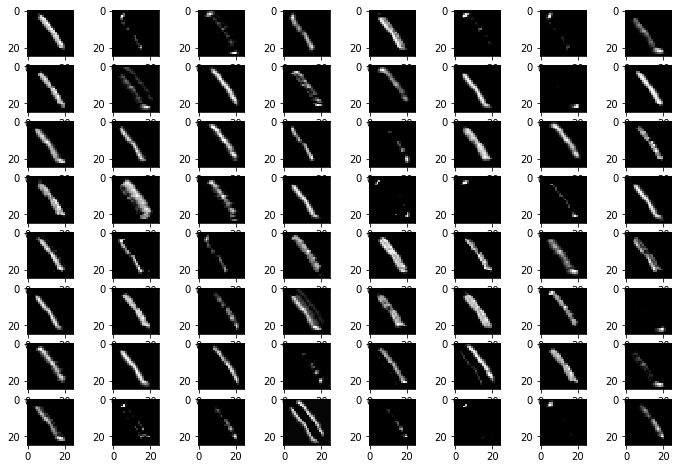

In [43]:
from tensorflow.keras import backend as K

def visualize(layer, img):
    convout1_f = K.function(model.inputs, [layer.output])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')
        
# choose an image
image = X_train[134,:,:]

# Keras requires the image to be in 4D
image = np.expand_dims(image, axis=0)
        
# Specify the layer to want to visualize
convout = model.layers[1]
visualize(convout, image)